In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

## Decision Tree class implementation

In [56]:
class DecisionTree:
    def __init__(self):
        self.tree = None
        self.features = list
        self.XTrain = np.array
        self.yTrain = np.array
        self.num_feats = int
        self.train_size = int
        self.nodes = 0

    def split_table(self, df, feature, pivot, operation):
        return df[operation(df[feature], pivot)].reset_index(drop=True)

    def fit(self, X, y):
        self.XTrain = X
        self.yTrain = y
        self.features = list(X.columns)
        self.train_size = X.shape[0]
        self.num_feats = X.shape[1]

        df = X.copy()
        df['category'] = y.copy()

        self.tree = self.make_subtree(df)
        # s = str(self.tree)
        # s = s.replace("\'", "\"")
        # json_object = json.loads(s)
        # print(json.dumps(json_object, option=json.OPT_INDENT_2).decode())

    def make_subtree(self, df, tree=None):
        feature, cutoff, igrmax = self.calc_feature_info(df)
        categories, count = np.unique(df['category'], return_counts=True)
        # print(f"Chosen {feature} with cutoff {cutoff}, Base node has {categories} with count {count}")
        if tree is None:
            tree = {feature: {}}
        if cutoff == None:
          tree[feature]['>=' + str(-1.5) + ' then'] = 1
          return tree
        
        self.nodes +=1  

        # Left Child
        new_df = self.split_table(df, feature, cutoff, operator.ge)
        categories, count = np.unique(new_df['category'], return_counts=True)
        # print(f"LEFT node has {categories} with count {count}")
        if len(count) == 1:  # all are same category
            tree[feature]['>=' + str(cutoff) + ' then'] = categories[0]
        else:
            tree[feature]['>=' + str(cutoff) + ' then'] = self.make_subtree(new_df)

        # Right Child
        new_df = self.split_table(df, feature, cutoff, operator.lt)
        categories, count = np.unique(new_df['category'], return_counts=True)
        # print(f"RIGHT node has {categories} with count {count}")
        if len(count) == 1:  # all are same category
            tree[feature]['else ' + '<' + str(cutoff)] = categories[0]
        else:
            tree[feature]['else ' + '<' + str(cutoff)] = self.make_subtree(new_df)

        return tree

    def entropy(self, df):
        entropy = 0
        for target in df['category'].unique():
            probability = df['category'].value_counts()[target] / len(df['category'])
            if probability>0:
                entropy -= probability * np.log2(probability)

        return entropy
    
    def calc_feature_info(self, df):
        ent_base = self.entropy(df)
        features = df.columns[:-1]
        datalen = len(df)

        max_info_gain_ratio = 0
        threshold = None
        chosen_feat = features[0]
        for feature in features:
            candid_points = sorted(df[feature].unique())
            for can_point in candid_points:
                total_ent = 0
                ent_weight = 0
                for op in [operator.lt,operator.ge]:
                    split_ = self.split_table(df, feature, can_point, op)

                    if len(split_)>0:
                        ent_ = self.entropy(split_)
                        total_ent += len(split_)*ent_/datalen
                        ent_weight += (len(split_)/datalen)*np.log2(datalen/len(split_))
                
                info_gain_ratio = (ent_base-total_ent)/ent_weight if ent_weight>0 else 0
                if info_gain_ratio>max_info_gain_ratio:
                    max_info_gain_ratio = info_gain_ratio
                    threshold = can_point
                    chosen_feat = feature
                # print(feature, can_point, info_gain_ratio, chosen_feat)

        return chosen_feat, threshold, max_info_gain_ratio

    def predict(self, X):
        results = []

        for i in range(len(X)):
            results.append(self.predict_X(X.iloc[i], self.tree))

        return np.array(results)

    def predict_X(self, x, tree):
        node = list(tree.keys())[0]
        val = x[node]
        cutoff = list(tree[node].keys())[0].split('>=')[1].split(' ')[0]

        if val >= float(cutoff):  # Left Child
            tree = tree[node]['>=' + cutoff + ' then']
        else:  # Right Child
            tree = tree[node]['else ' + '<' + cutoff]

        if type(tree) is dict:
            return self.predict_X(x, tree)
        else:
            return tree


In [93]:
def error_score(ytrue, ypred):
    return (sum(ypred != ytrue)*100.0)/len(ytrue)

## Question 7

### Loading and Splitting the Data

In [94]:
data = pd.read_table("data/Dbig.txt", sep=" ", header=None, names=["X1", "X2", "Y"])
print(data.head())

         X1        X2  Y
0 -1.499372  0.976384  1
1 -1.499224 -0.517983  1
2 -1.498880 -1.271624  1
3 -1.498383  1.456647  1
4 -1.498293 -1.290862  1


In [95]:
data_train = data.sample(frac=0.8192, random_state=1234)
print("Train data shape ",data_train.shape)
data_test = data.drop(data_train.index).reset_index(drop=True)
data_train.reset_index(drop=True, inplace=True)
print("Test data shape ",data_test.shape)

split_count = [32,128,512,2048,8192]
cols = list(data.columns)
data_train_n = {}
for i in split_count:
    data_train_n[i] = data_train.sample(frac=(i/8192), random_state=1234).reset_index(drop=True)

Train data shape  (8192, 3)
Test data shape  (1808, 3)


### Training the Decision Tree and calculating Error on test set

In [96]:
dt_clf_n = {}
error_n  = {}
for i in split_count:
    X, y = data_train_n[i].loc[:,cols[:-1]], data_train_n[i].loc[:,cols[-1]]
    dt_clf_n[i] = DecisionTree()
    dt_clf_n[i].fit(X, y)
    X_test, y_test = data_test.loc[:,cols[:-1]], data_test.loc[:,cols[-1]]
    error_n[i] = error_score(y_test, dt_clf_n[i].predict(X_test))

In [99]:
for keys, value in dt_clf_n.items():
    print(f"For n= {keys} training samples,\tnodes= {value.nodes}")

print()
for keys, value in error_n.items():
    print(f"For n= {keys} training samples,\ttest error= {round(value,2)}%")

For n= 32 training samples,	nodes= 4
For n= 128 training samples,	nodes= 14
For n= 512 training samples,	nodes= 29
For n= 2048 training samples,	nodes= 68
For n= 8192 training samples,	nodes= 126

For n= 32 training samples,	test error= 16.37%
For n= 128 training samples,	test error= 9.07%
For n= 512 training samples,	test error= 5.25%
For n= 2048 training samples,	test error= 4.37%
For n= 8192 training samples,	test error= 1.99%


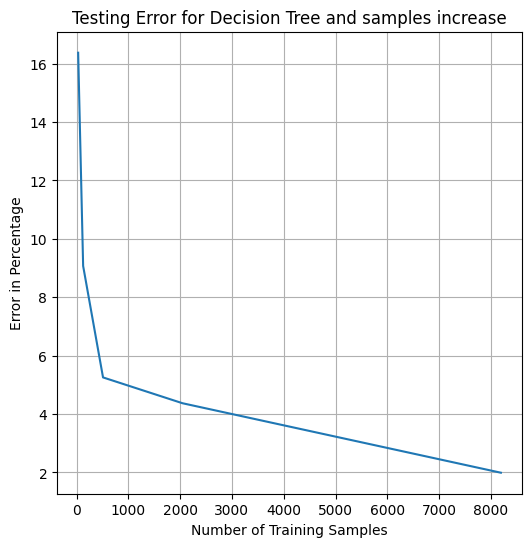

In [100]:
fig = plt.figure(num=None, figsize=(6, 6))
plt.plot(list(error_n.keys()),list(error_n.values()))
plt.ylabel("Error in Percentage")
plt.xlabel("Number of Training Samples")
plt.title(f"Testing Error for Decision Tree and samples increase")
plt.grid(axis='both')
plt.show()

### Plotting the decision boundary and the training samples over it

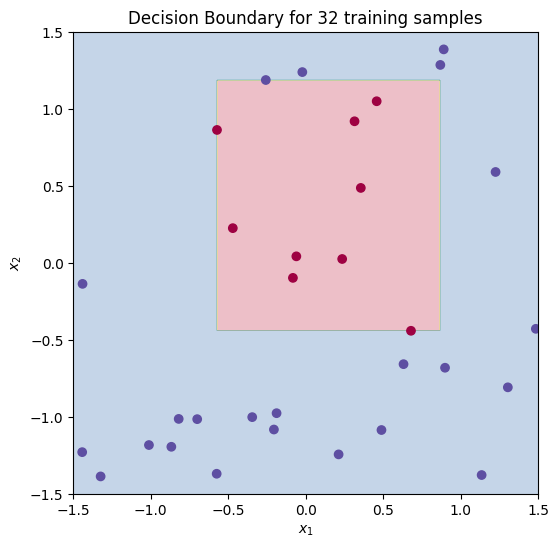

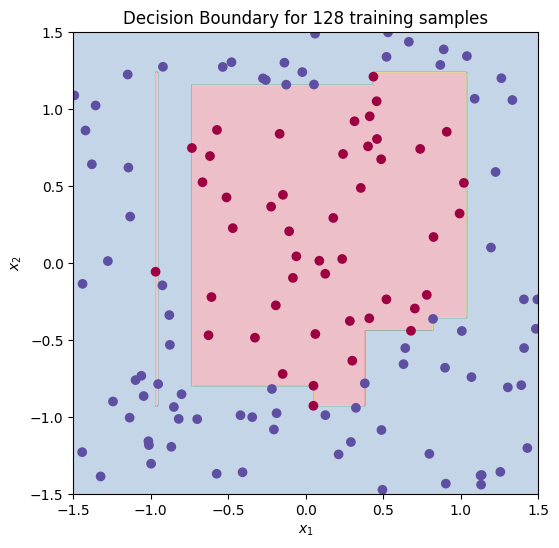

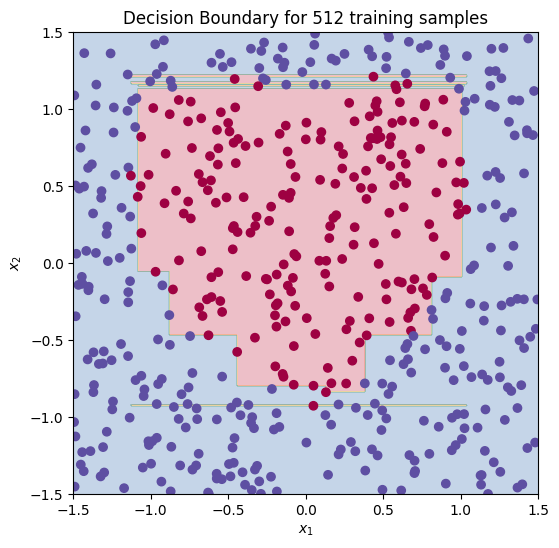

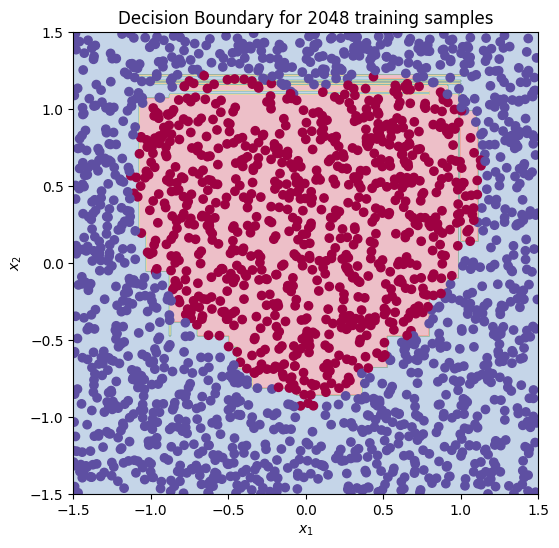

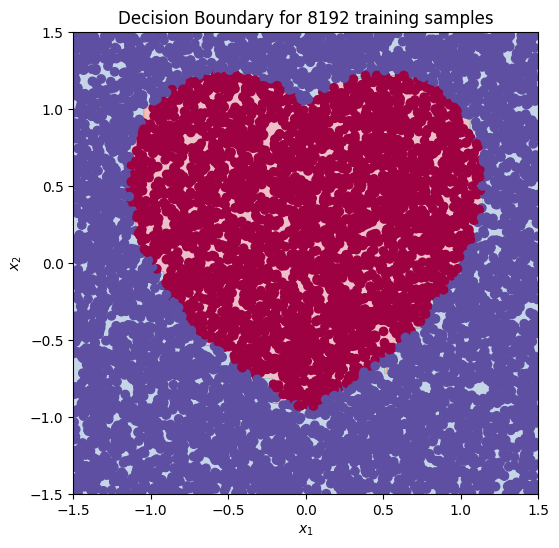

In [62]:
for i in split_count:
    X, y = data_train_n[i].loc[:,cols[:-1]], data_train_n[i].loc[:,cols[-1]]
    n = 400
    x1 = np.linspace(-1.5, 1.5, n)
    x2 = np.linspace(-1.5, 1.5, n)

    x = np.array(np.meshgrid(x1,x2)).reshape(2,-1)
    x = pd.DataFrame(x.T)
    x.columns = ["X1","X2"]
    decision_space = np.asarray(dt_clf_n[i].predict(x))
    decision_space = decision_space.reshape(400,400)
                
    fig = plt.figure(num=None, figsize=(6, 6))
    plt.contourf(x1, x2, decision_space, alpha=0.3, cmap='Spectral')
    plt.scatter(X['X1'],X['X2'],c=y,cmap='Spectral')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"Decision Boundary for {i} training samples")
    plt.show()